In [1]:
import json
from datetime import datetime

In [2]:
t = '0:01:45'

time = datetime.strptime(t, '%H:%M:%S').time()
time.second

def time_to_seconds(t):
    time = datetime.strptime(t, '%H:%M:%S').time()
    return time.hour*3600 + time.minute*60 + time.second

def seconds_to_time(s):
    return datetime.utcfromtimestamp(s).strftime('%H:%M:%S')

print(time_to_seconds(t))
print(seconds_to_time(time_to_seconds(t)))

105
00:01:45


In [3]:
from collections import defaultdict

episodes_data = json.load(open('../data/raw/episodes.json', 'r'))
characters_data = json.load(open('../data/raw/characters.json', 'r'))
colors = json.load(open('../data/raw/colors.json', 'r'))
colors = colors['houses']


episodes = episodes_data['episodes']
print('Number of episodes:', len(episodes))

characters = set()
characters_by_season = {}

for episode in episodes:
    season = episode['seasonNum']
    scenes = episode['scenes']
    for scene in scenes:
        scene_length = time_to_seconds(scene['sceneEnd']) - time_to_seconds(scene['sceneStart'])
        scene['sceneLength'] = scene_length
        for character in scene['characters']:
            name = character['name']
            characters.add(name)
            if season not in characters_by_season:
                characters_by_season[season] = set()
            characters_by_season[season].add(name)

# Sort characters characters_by_season
characters = sorted(list(characters))
for season in characters_by_season:
    characters_by_season[season] = sorted(list(characters_by_season[season]))

# Create a dict of character name to color
character_colors = defaultdict(lambda: '#ceccd7')
for character in characters_data['characters']:
    name = character['characterName']

    if name not in characters:
        continue
    
    if 'houseName' in character:
        if isinstance(character['houseName'], list):
            house = character['houseName'][0]
        else:
            house = character['houseName']

        if house in colors:
            character_colors[name] = colors[house]
        else:
            print("WARNING missing color for house:", house)

Number of episodes: 73
WARNING missing color for house: Arryn
WARNING missing color for house: Umber
WARNING missing color for house: Tarly


In [4]:
for c in characters:
    character_colors[c]

In [5]:
print("Number of total characters:", len(characters))
print('Number of characters per season:')
for season in characters_by_season:
    print(season, len(characters_by_season[season]))
print('\n\n')

def episodes_from_season(data, season):
    return [episode for episode in data if episode['seasonNum'] == season]

def make_matrix(episodes, characters):
    # Make a 2d matrix of characters x characters
    matrix = []
    for i in range(len(characters)):
        matrix.append([0]*len(characters))
    
    for episode in episodes:
        for scene in episode['scenes']:
            sceneLength = scene['sceneLength']
            characters_in_scene = scene['characters']
            characters_in_scene = [character['name'] for character in characters_in_scene]

            # Fill in the matrix
            for i in range(len(characters_in_scene)):
                for j in range(len(characters_in_scene)):
                    # Skip diagonal, can be recomputed as sum(row)
                    if i != j:
                        matrix[characters.index(characters_in_scene[i])][characters.index(characters_in_scene[j])] += sceneLength

    return matrix

season_1_matrix = make_matrix(episodes_from_season(episodes, 1), characters_by_season[1])
season_2_matrix = make_matrix(episodes_from_season(episodes, 2), characters_by_season[2])
season_3_matrix = make_matrix(episodes_from_season(episodes, 3), characters_by_season[3])
season_4_matrix = make_matrix(episodes_from_season(episodes, 4), characters_by_season[4])
season_5_matrix = make_matrix(episodes_from_season(episodes, 5), characters_by_season[5])
season_6_matrix = make_matrix(episodes_from_season(episodes, 6), characters_by_season[6])
season_7_matrix = make_matrix(episodes_from_season(episodes, 7), characters_by_season[7])
season_8_matrix = make_matrix(episodes_from_season(episodes, 8), characters_by_season[8])

complete_matrix = make_matrix(episodes, characters)

Number of total characters: 577
Number of characters per season:
1 125
2 137
3 137
4 152
5 175
6 208
7 75
8 66





In [6]:
total_time = 0
for episode in episodes:
    for scene in episode['scenes']:
        total_time += scene['sceneLength']
print ('Total time:', total_time)

# Calculate hours, minutes, and seconds
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f'{hours} hours, {minutes} minutes, {seconds} seconds')


Total time: 237423
65 hours, 57 minutes, 3 seconds


In [7]:
def top_n_characters(matrix, characters, n=50):
    summed_times = [(idx, sum(row)) for (idx, row) in enumerate(matrix)]
    summed_times = sorted(summed_times, key=lambda x: x[1], reverse=True)
    top_n = summed_times[:n]
    top_n = [(characters[idx], time) for (idx, time) in top_n]
    return top_n

top_50_full = top_n_characters(complete_matrix, characters)
top_50_full

[('Tyrion Lannister', 162382),
 ('Jon Snow', 161827),
 ('Daenerys Targaryen', 134582),
 ('Sansa Stark', 124635),
 ('Cersei Lannister', 107369),
 ('Davos Seaworth', 100864),
 ('Jorah Mormont', 97254),
 ('Lord Varys', 91907),
 ('Arya Stark', 87792),
 ('Jaime Lannister', 87201),
 ('Missandei', 81637),
 ('Bran Stark', 81050),
 ('Brienne of Tarth', 80241),
 ('Sandor Clegane', 72912),
 ('Theon Greyjoy', 69569),
 ('Samwell Tarly', 68403),
 ('Grey Worm', 64867),
 ('Tormund Giantsbane', 58457),
 ('Joffrey Baratheon', 57051),
 ('Petyr Baelish', 48827),
 ('Yohn Royce', 42127),
 ('Catelyn Stark', 41527),
 ('Grand Maester Pycelle', 40894),
 ('Eddard Stark', 40189),
 ('Gendry', 40009),
 ('Gregor Clegane', 37619),
 ('Tywin Lannister', 35936),
 ('Tommen Baratheon', 35370),
 ('Podrick Payne', 34900),
 ('Barristan Selmy', 34490),
 ('Margaery Tyrell', 33797),
 ('Eddison Tollett', 32829),
 ('Qhono', 31292),
 ('Robb Stark', 31173),
 ('Bronn', 30352),
 ('Qyburn', 28818),
 ('Drogon', 28648),
 ('Mace Tyrell',

In [8]:
def normalize_matrix(matrix):
    normalized_matrix = []
    for row in matrix:
        total = sum(row)
        if total == 0:
            normalized_matrix.append(row)
            continue
        normalized_row = [val/total for val in row]
        normalized_matrix.append(normalized_row)
    return normalized_matrix

season_1_mat_norm = normalize_matrix(season_1_matrix)
season_2_mat_norm = normalize_matrix(season_2_matrix)
season_3_mat_norm = normalize_matrix(season_3_matrix)
season_4_mat_norm = normalize_matrix(season_4_matrix)
season_5_mat_norm = normalize_matrix(season_5_matrix)
season_6_mat_norm = normalize_matrix(season_6_matrix)
season_7_mat_norm = normalize_matrix(season_7_matrix)
season_8_mat_norm = normalize_matrix(season_8_matrix)
complete_mat_norm = normalize_matrix(complete_matrix)

In [9]:
def is_symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j] != matrix[j][i]:
                return False
    return True

def matrix_eye(matrix):
    eye = [matrix[i][i] for i in range(len(matrix))]
    return any(eye)

print(is_symmetrical(season_1_mat_norm))
print(is_symmetrical(season_2_mat_norm))
print(is_symmetrical(season_3_mat_norm))
print(is_symmetrical(season_4_mat_norm))
print(is_symmetrical(season_5_mat_norm))
print(is_symmetrical(season_6_mat_norm))
print(is_symmetrical(season_7_mat_norm))
print(is_symmetrical(season_8_mat_norm))
print(is_symmetrical(complete_mat_norm))

print('--------------')
print(matrix_eye(season_1_mat_norm))
print(matrix_eye(season_2_mat_norm))
print(matrix_eye(season_3_mat_norm))
print(matrix_eye(season_4_mat_norm))
print(matrix_eye(season_5_mat_norm))
print(matrix_eye(season_6_mat_norm))
print(matrix_eye(season_7_mat_norm))
print(matrix_eye(season_8_mat_norm))
print(matrix_eye(complete_mat_norm))


False
False
False
False
False
False
False
False
False
--------------
False
False
False
False
False
False
False
False
False


We have 2 connected components


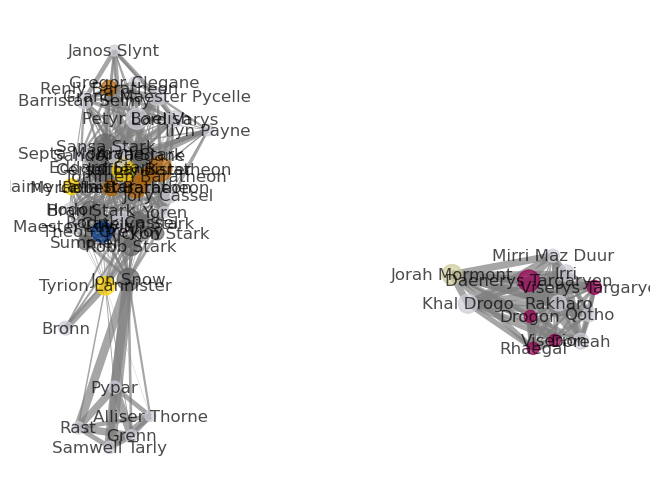

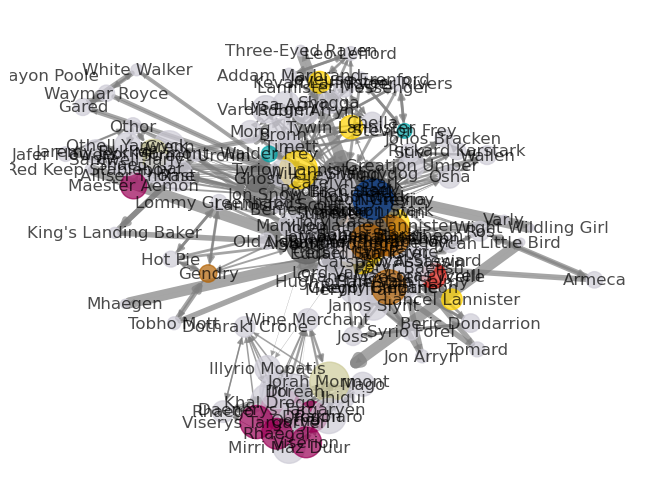

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from math import pi, sqrt

def make_graph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    G = nx.Graph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        G.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                interaction_time = matrix_norm[i][j]
                if interaction_time == 0.0:
                    continue
                G.add_edge(characters[i], characters[j], interaction_time=interaction_time)
    return G

def make_digraph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    DG = nx.DiGraph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        DG.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                interaction_time = matrix_norm[i][j]
                if interaction_time == 0.0:
                    continue
                DG.add_edge(characters[i], characters[j], interaction_time=interaction_time)
    return DG

def area_to_radius(area):
    return  (area / pi)**0.5

def color_nodes(G):
    colors = []
    for node in G.nodes():
        colors.append(character_colors[node])
    return colors

def draw_graph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [v*0.01 for v in node_sizes]
    edges = G.edges()
    widths = [G[u][v]['interaction_time'] * 35 for u,v in edges]
    k = 1 / sqrt(len(G.nodes())) * 4
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=widths,
    )

def draw_digraph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [area_to_radius(v) * 10 for v in node_sizes]
    edge_widths = [G[u][v]['interaction_time'] * 8 for u,v in G.edges()]
    k = 1 / sqrt(len(G.nodes())) * 5
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=edge_widths,
    )

G_S1 = make_graph(season_1_matrix, characters_by_season[1])

# Limit to top 50 notes
nodes = G_S1.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]
G_S1 = G_S1.subgraph([node[0] for node in nodes])
DG_S1 = make_digraph(season_1_matrix, characters_by_season[1])
print("We have", nx.number_connected_components(G_S1), "connected components")


plt.figure(1)
draw_graph(G_S1)
plt.figure(2)
draw_digraph(DG_S1)  
plt.show()

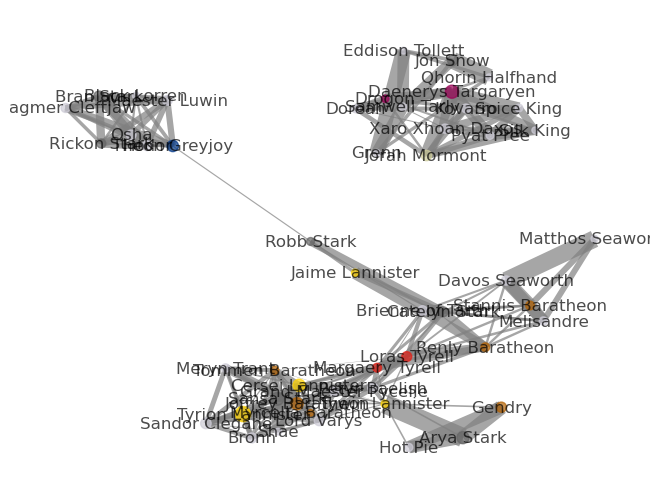

In [11]:
G_S2 = make_graph(season_2_matrix, characters_by_season[2])

# Limit to top 50 notes
nodes = G_S2.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S2_top50 = G_S2.subgraph([node[0] for node in nodes])
draw_graph(G_S2_top50)

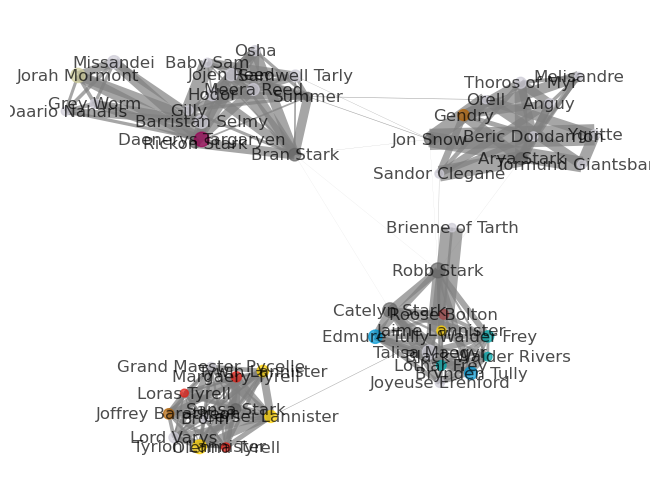

In [12]:
G_S3 = make_graph(season_3_matrix, characters_by_season[3])

# Limit to top 50 notes
nodes = G_S3.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S3_top50 = G_S3.subgraph([node[0] for node in nodes])
draw_graph(G_S3_top50)

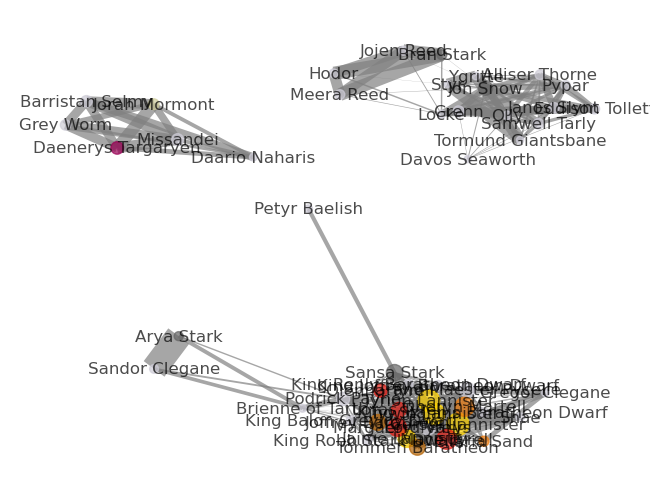

In [13]:
G_S4 = make_graph(season_4_matrix, characters_by_season[4])

# Limit to top 50 notes
nodes = G_S4.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S4_top50 = G_S4.subgraph([node[0] for node in nodes])
draw_graph(G_S4_top50)

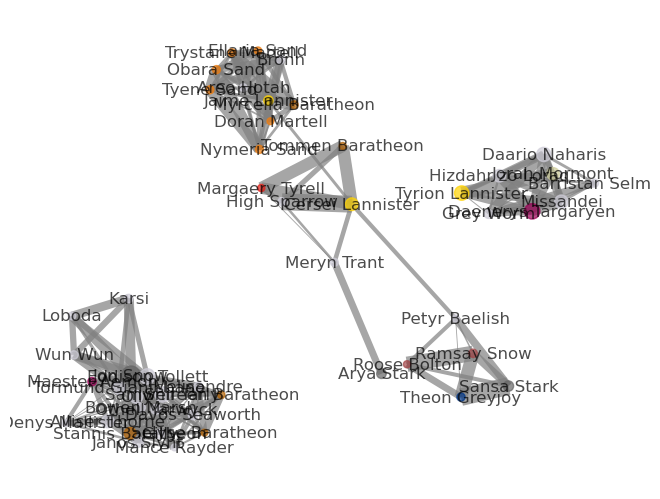

In [14]:
G_S5 = make_graph(season_5_matrix, characters_by_season[5])

# Limit to top 50 notes
nodes = G_S5.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S5_top50 = G_S5.subgraph([node[0] for node in nodes])
draw_graph(G_S5_top50)

In [15]:
G_S6 = make_graph(season_6_matrix, characters_by_season[6])
G_S7 = make_graph(season_7_matrix, characters_by_season[7])

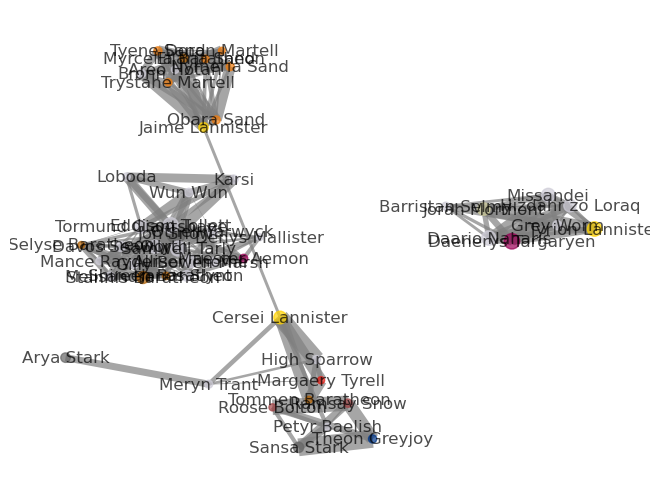

In [16]:
G_S8 = make_graph(season_8_matrix, characters_by_season[8])

# Limit to top 50 notes
nodes = G_S8.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_S8_top50 = G_S8.subgraph([node[0] for node in nodes])
draw_graph(G_S5_top50)

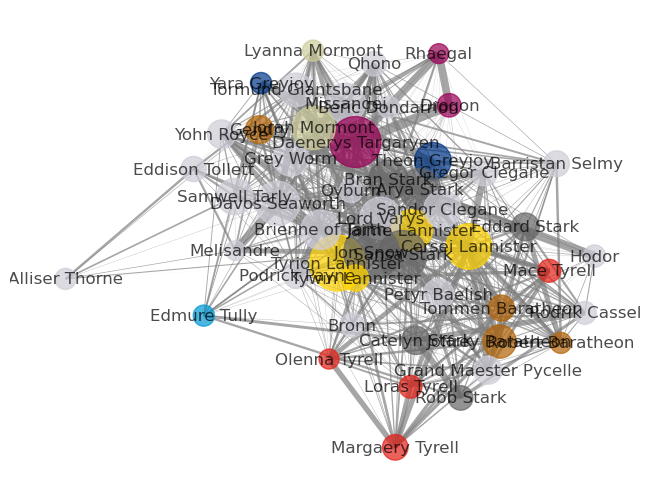

In [17]:
G_complete = make_graph(complete_matrix, characters)

# Limit to top 50 notes
nodes = G_complete.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]

G_complete_top = G_complete.subgraph([node[0] for node in nodes])
draw_graph(G_complete_top)

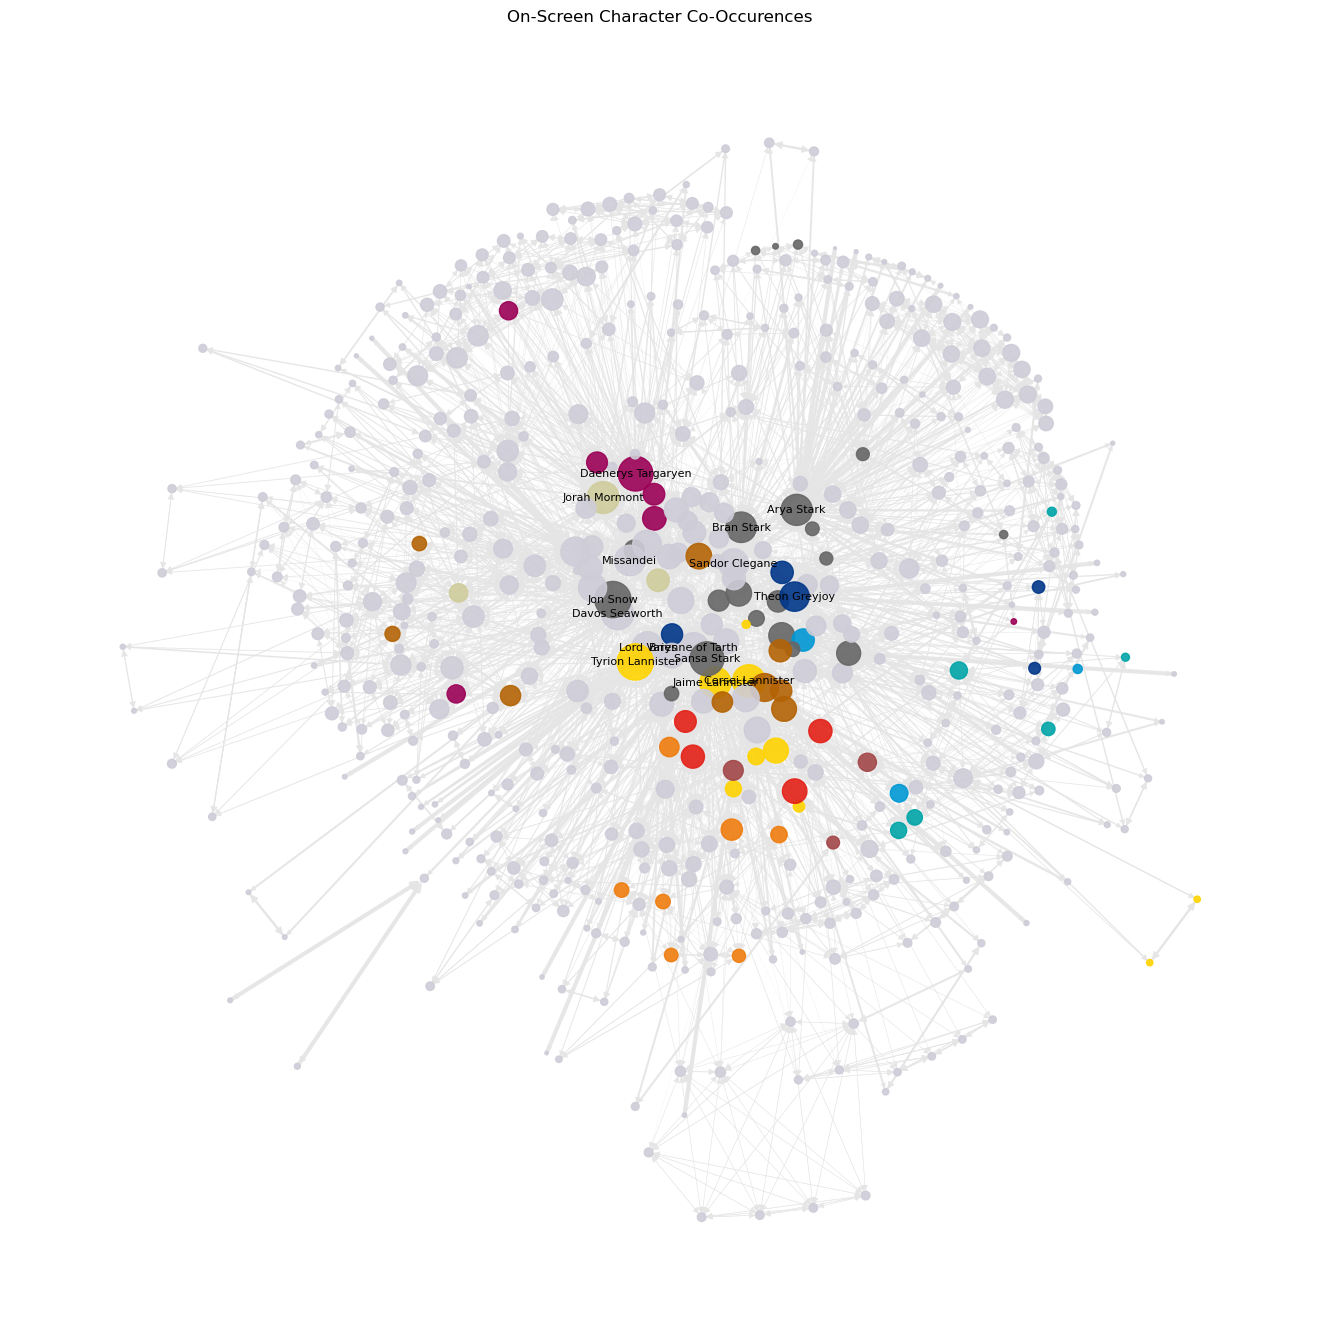

In [18]:
DG_complete = make_digraph(complete_matrix, characters)

top_nodes = sorted(
    G_complete.nodes(data=True), key=lambda x: x[1]["total_time"], reverse=True
)[:15]
top_labels = {node: node for node, _ in top_nodes}

# Parameters
node_scaling = 3
edge_width_scaling = 3
edge_weight_scaling = 0.5

node_sizes = [
    area_to_radius(v) * node_scaling
    for v in nx.get_node_attributes(DG_complete, "total_time").values()
]

# for u, v, data in DG_complete.edges(data=True):
#    data['interaction_time'] *= edge_weight_scaling

edge_widths = [
    DG_complete[u][v]["interaction_time"] * edge_width_scaling
    for u, v in DG_complete.edges()
]
# pos = nx.spring_layout(DG_complete, k=1 / sqrt(len(DG_complete.nodes())) * 6)
pos = nx.kamada_kawai_layout(DG_complete)

plt.figure(figsize=(13, 13))
nx.draw(
    DG_complete,
    pos=pos,
    with_labels=False,
    edge_color="#e5e5e5",#'grey",
    node_size=node_sizes,
    node_color=color_nodes(DG_complete),
    alpha=0.9,
    font_color="black",
    width=edge_widths,
)
nx.draw_networkx_labels(
    DG_complete, pos, labels=top_labels, font_size=8, font_color="black"
)
plt.title("On-Screen Character Co-Occurences")
plt.show()

# Degree Distribution, Centrality and other measures

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

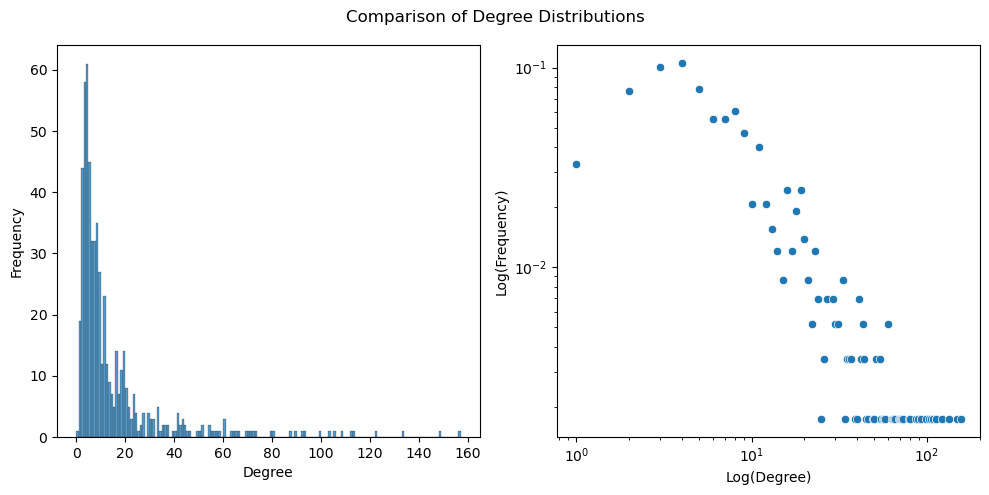

In [20]:
complete_degree_sequence = [d for _, d in G_complete.degree()]
hist, bin_edges = np.histogram(complete_degree_sequence, bins=range(min(complete_degree_sequence), max(complete_degree_sequence) + 2), density=True)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Comparison of Degree Distributions')

sns.histplot(x=complete_degree_sequence, ax=ax0, bins=range(min(complete_degree_sequence), max(complete_degree_sequence) + 2))
ax0.set_xlabel('Degree')
ax0.set_ylabel('Frequency')

sns.scatterplot(x=bin_edges[:-1], y=hist, ax=ax1, marker='o')
plt.xscale('log')
plt.yscale('log')
ax1.set_xlabel('Log(Degree)')
ax1.set_ylabel('Log(Frequency)')

fig.tight_layout()
plt.show()


## Degree Distribution over all seasons

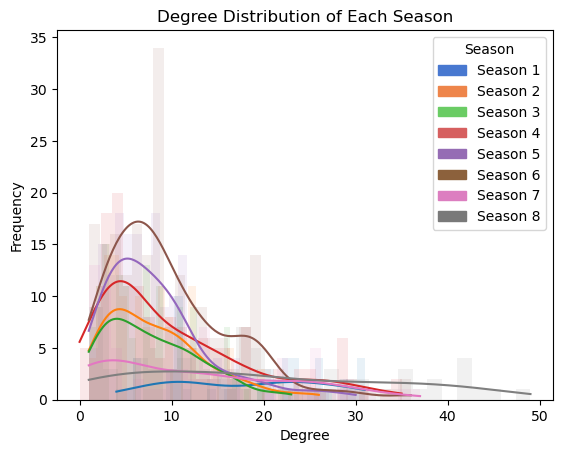

In [21]:
from matplotlib.patches import Patch

def generate_legend():
    # Define your rectangles and corresponding labels
    season_color_palette = sns.palettes.color_palette("muted", 8)
    rectangles = [Patch(color=c, label=f'Season {i+1}') for i, c in enumerate(season_color_palette)]
    return rectangles

season_graphs = [G_S1, G_S2, G_S3, G_S4, G_S5, G_S6, G_S7, G_S8]
season_degrees = zip(
    [f"Season {i}" for i in range(1, len(season_graphs) + 1)],
    [[d for _, d in G_season.degree()] for G_season in season_graphs],
)

for season, degree_sequence in season_degrees:
    sns.histplot(
        degree_sequence,
        bins=30,
        kde=True,
        label=season,
        edgecolor=None,
        alpha=0.1,
        legend=False,
        #kde_kws={'alpha': 0.5}  # Adjust the alpha for KDE
    )

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Each Season")
plt.legend(title="Season", handles=generate_legend(), loc='upper right')

plt.show()


In [22]:
# The most influential characters by highest degree for every season
from tabulate import tabulate

def top_characters_per_season(G, n=10):
    node_degrees = [(node, degree) for node, degree in G.degree()]
    sorted_nodes = sorted(node_degrees, key=lambda x: x[1], reverse=True)

    # Return the top n nodes with their degrees
    return sorted_nodes[:n]

def pp(season, top_characters):
    table = tabulate(top_characters, headers=['Character', 'Degree'], tablefmt="presto")
    print(f"Most influential characters in season {season}:\n\n{table}\n\n")

for i, g in enumerate(season_graphs):
    pp(i+1, top_characters_per_season(g))

Most influential characters in season 1:

 Character         |   Degree
-------------------+----------
 Joffrey Baratheon |       31
 Eddard Stark      |       31
 Cersei Lannister  |       31
 Sandor Clegane    |       31
 Sansa Stark       |       30
 Robert Baratheon  |       29
 Arya Stark        |       29
 Jon Snow          |       27
 Rodrik Cassel     |       26
 Catelyn Stark     |       26


Most influential characters in season 2:

 Character         |   Degree
-------------------+----------
 Tyrion Lannister  |       26
 Joffrey Baratheon |       25
 Sansa Stark       |       24
 Cersei Lannister  |       23
 Arya Stark        |       20
 Bronn             |       20
 Sandor Clegane    |       20
 Petyr Baelish     |       19
 Brienne of Tarth  |       18
 Theon Greyjoy     |       18


Most influential characters in season 3:

 Character        |   Degree
------------------+----------
 Robb Stark       |       23
 Samwell Tarly    |       22
 Tyrion Lannister |       22
 S

In [23]:
top_characters = {c for g in season_graphs for c, _ in top_characters_per_season(g)}
top_characters

{'Arya Stark',
 'Bran Stark',
 'Brienne of Tarth',
 'Bronn',
 'Brynden Tully',
 'Catelyn Stark',
 'Cersei Lannister',
 'Daario Naharis',
 'Daenerys Targaryen',
 'Davos Seaworth',
 'Drogon',
 'Eddard Stark',
 'Eddison Tollett',
 'Grey Worm',
 'Jaime Lannister',
 'Joffrey Baratheon',
 'Jon Snow',
 'Jorah Mormont',
 'Lord Varys',
 'Margaery Tyrell',
 'Melisandre',
 'Meryn Trant',
 'Missandei',
 'Oberyn Martell',
 'Olly',
 'Petyr Baelish',
 'Podrick Payne',
 'Robb Stark',
 'Robert Baratheon',
 'Rodrik Cassel',
 'Roose Bolton',
 'Samwell Tarly',
 'Sandor Clegane',
 'Sansa Stark',
 'Stannis Baratheon',
 'Talisa Maegyr',
 'Theon Greyjoy',
 'Tormund Giantsbane',
 'Tyrion Lannister',
 'Tywin Lannister'}

In [24]:
character_names = [
    "Tyrion Lannister",
    "Jaime Lannister",
    "Tywin Lannister",
    "Stannis Baratheon",
    "Jon Snow",
    "Arya Stark",
    "Sansa Stark",
    "Robb Stark",
    "Bran Stark",
]

for idx, g in enumerate(season_graphs):
    for c in character_names:
        if not g.has_node(c):
            print(f"Season {idx+1} graph is missing {c}")

for c in character_names:
    if not G_complete.has_node(c):
        print(c)

Season 1 graph is missing Tywin Lannister
Season 1 graph is missing Stannis Baratheon
Season 4 graph is missing Robb Stark
Season 5 graph is missing Robb Stark
Season 5 graph is missing Bran Stark
Season 6 graph is missing Tywin Lannister
Season 6 graph is missing Stannis Baratheon
Season 7 graph is missing Tywin Lannister
Season 7 graph is missing Stannis Baratheon
Season 7 graph is missing Robb Stark
Season 8 graph is missing Tywin Lannister
Season 8 graph is missing Stannis Baratheon
Season 8 graph is missing Robb Stark


In [25]:
chart_characters = [
    {"Name": "Tyrion Lannister", "Color": "red"},
    {"Name": "Jaime Lannister", "Color": "blue"},
    {"Name": "Tywin Lannister", "Color": "green"},
    {"Name": "Stannis Baratheon", "Color": "cyan"},
    {"Name": "Jon Snow", "Color": "orange"},
    {"Name": "Arya Stark", "Color": "purple"},
    {"Name": "Sansa Stark", "Color": "brown"},
    {"Name": "Robb Stark", "Color": "pink"},
    {"Name": "Bran Stark", "Color": "grey"},
]

chart_names = [c["Name"] for c in chart_characters]
for idx, character in enumerate([c["Name"] for c in chart_characters]):
    ranks = []
    for g in season_graphs:
        rank = g.degree(character) if g.has_node(character) else None
        ranks.append(rank)

    chart_characters[idx]["Ranks"] = ranks

chart_characters

[{'Name': 'Tyrion Lannister',
  'Color': 'red',
  'Ranks': [23, 26, 22, 35, 19, 18, 30, 49]},
 {'Name': 'Jaime Lannister',
  'Color': 'blue',
  'Ranks': [23, 10, 9, 24, 14, 36, 25, 29]},
 {'Name': 'Tywin Lannister',
  'Color': 'green',
  'Ranks': [None, 17, 12, 29, 2, None, None, None]},
 {'Name': 'Stannis Baratheon',
  'Color': 'cyan',
  'Ranks': [None, 9, 5, 14, 21, None, None, None]},
 {'Name': 'Jon Snow',
  'Color': 'orange',
  'Ranks': [27, 11, 15, 31, 30, 31, 37, 37]},
 {'Name': 'Arya Stark',
  'Color': 'purple',
  'Ranks': [29, 20, 13, 13, 25, 24, 14, 42]},
 {'Name': 'Sansa Stark',
  'Color': 'brown',
  'Ranks': [30, 24, 20, 35, 15, 27, 17, 41]},
 {'Name': 'Robb Stark',
  'Color': 'pink',
  'Ranks': [21, 16, 23, None, None, 6, None, None]},
 {'Name': 'Bran Stark',
  'Color': 'grey',
  'Ranks': [23, 14, 14, 14, None, 29, 14, 42]}]

7 Tyrion Lannister
Tyrion Lannister xy: Season 8 49
Tyrion Lannister xytext: Season 8 48.5
7 Jaime Lannister
Jaime Lannister xy: Season 8 29
Jaime Lannister xytext: Season 8 28.5
4 Tywin Lannister
Tywin Lannister xy: Season 5 2
Tywin Lannister xytext: Season 5 1.5
4 Stannis Baratheon
Stannis Baratheon xy: Season 5 21
Stannis Baratheon xytext: Season 5 20.5
7 Jon Snow
Jon Snow xy: Season 8 37
Jon Snow xytext: Season 8 36.5
7 Arya Stark
Arya Stark xy: Season 8 42
Arya Stark xytext: Season 8 41.5
7 Sansa Stark
Sansa Stark xy: Season 8 41
Sansa Stark xytext: Season 8 40.5
5 Robb Stark
Robb Stark xy: Season 6 6
Robb Stark xytext: Season 6 5.5
7 Bran Stark
Bran Stark xy: Season 8 42
Bran Stark xytext: Season 8 41.5


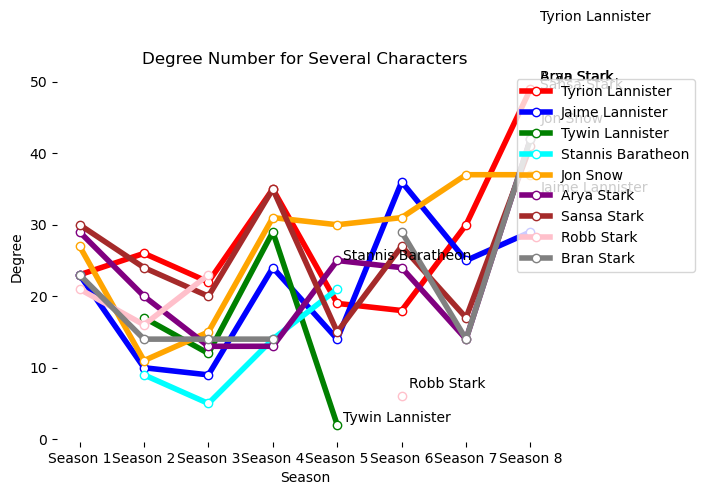

In [26]:
fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = (20, 8)

x_axis = [f"Season {i+1}" for i in range(len(season_graphs))]
#x_axis = [i+1 for i in range(len(season_graphs))]
for ele in chart_characters:
    name, ranks = ele["Name"], ele["Ranks"]
    ax.plot(
        x_axis,
        ranks,
        label=name,
        marker="o",
        markerfacecolor="white",
        color=ele["Color"],
        linewidth=4,
    )

    last_present_value = next(
        idx for idx, x in enumerate(reversed(ranks)) if x is not None
    )
    last_present_value = len(ranks) - last_present_value - 1
    print(last_present_value, name)

    print(name, "xy:", x_axis[last_present_value], ranks[last_present_value])
    print(name, "xytext:", x_axis[last_present_value], ranks[last_present_value] - 0.5)
    ax.annotate(
        name,
        xy=(x_axis[last_present_value], ranks[last_present_value]),
        xytext=(x_axis[last_present_value], ranks[last_present_value]),
        #xy=(x_axis[last_present_value], ranks[last_present_value]),
        #xytext=(x_axis[last_present_value], ranks[last_present_value]),
        textcoords="offset points"
    )

for spine in ax.spines.values():
    spine.set_visible(False)

plt.xlabel("Season")
plt.ylabel("Degree")
plt.title("Degree Number for Several Characters")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()